Iteration 1: Residual Mean = 0.2399, Residual Std Dev = 52.1034
Iteration 2: Residual Mean = 0.2458, Residual Std Dev = 52.1477
Iteration 2: Covariance Matrix Difference = 88881.6609
Iteration 3: Residual Mean = 0.2435, Residual Std Dev = 51.2796
Iteration 3: Covariance Matrix Difference = 41763.0192
Iteration 4: Residual Mean = 0.2379, Residual Std Dev = 50.0819
Iteration 4: Covariance Matrix Difference = 18302.1029
Iteration 5: Residual Mean = 0.2314, Residual Std Dev = 48.8131
Iteration 5: Covariance Matrix Difference = 6893.2748
Iteration 6: Residual Mean = 0.2248, Residual Std Dev = 47.5788
Iteration 6: Covariance Matrix Difference = 1406.2170
Iteration 7: Residual Mean = 0.2186, Residual Std Dev = 46.4181
Iteration 7: Covariance Matrix Difference = 1226.3859
Iteration 8: Residual Mean = 0.2130, Residual Std Dev = 45.3420
Iteration 8: Covariance Matrix Difference = 2436.5652
Iteration 9: Residual Mean = 0.2078, Residual Std Dev = 44.3501
Iteration 9: Covariance Matrix Difference =

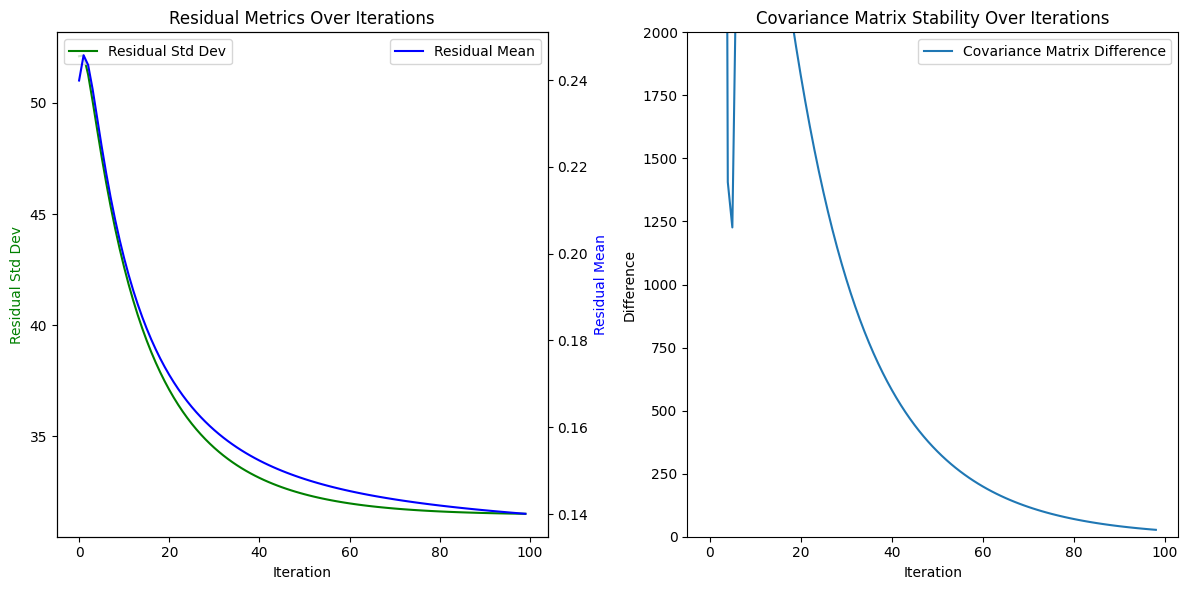

In [1]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Load the cleaned dataset
data_cleaned = pd.read_csv('../../../Data_processing/Outputs/train.csv')

# exclusion or inclusion only rejection samples
data_cleaned = data_cleaned.loc[data_cleaned['usubjid'].isin(data_cleaned[data_cleaned['label'] == 1]["usubjid"].unique())]
data_cleaned.dropna(inplace=True)

# Preprocess the data # separte predictor separately 
features = ['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
target = 'label'

# Group data by 'usubjid' to maintain sequence structure
grouped_data = data_cleaned.groupby('usubjid')

# Assuming you have a grouped dataframe called 'grouped_df'
shuffled_df = grouped_data.sample(frac=1, random_state=42)
shuffled_df = shuffled_df.sort_values(['usubjid', 'ady_dna'])

# Reset the index of the shuffled dataframe
grouped_data = shuffled_df.reset_index(drop=True)
grouped_data = grouped_data.groupby('usubjid')

X_grouped = [group[['aval_AlloSure', 'aval_AlloMap', "ady_dna"]].values for name, group in grouped_data]
y_grouped = [group['label'].values for name, group in grouped_data]

# Calculate the split index for 80%/20%
split_index = int(0.80 * len(X_grouped))

# Split the sequences into training and testing sets
X_train_grouped = X_grouped[:split_index]
X_test_grouped = X_grouped[split_index:]
y_train_grouped = y_grouped[:split_index]
y_test_grouped = y_grouped[split_index:]

# Concatenate the sequences to form the training and testing sets
X_train = np.concatenate(X_train_grouped)
X_test = np.concatenate(X_test_grouped)
y_train = np.concatenate(y_train_grouped)
y_test = np.concatenate(y_test_grouped)

# Initialize the Kalman Filter
kf = KalmanFilter(initial_state_mean=np.zeros(X_train.shape[1]),
                  n_dim_obs=X_train.shape[1],
                  n_dim_state=X_train.shape[1])

# Lists to store metrics for plotting
residual_means = []
residual_stds = []
covariance_diffs = []

# Estimate the Kalman Filter parameters using EM algorithm and track convergence metrics
prev_covariance_matrix = None
for i in range(100):
    kf = kf.em(X_train, n_iter=1)
    
    # Use the filter to estimate the hidden states
    state_means, state_covariances = kf.filter(X_test)
    
    # Calculate residuals
    residuals = X_test - state_means
    
    # Metric 1: Residual Analysis
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    
    residual_means.append(residual_mean)
    residual_stds.append(residual_std)
    
    print(f"Iteration {i+1}: Residual Mean = {residual_mean:.4f}, Residual Std Dev = {residual_std:.4f}")
    
    # Metric 2: Covariance Matrix Stability
    if prev_covariance_matrix is not None:
        covariance_diff = np.linalg.norm(state_covariances - prev_covariance_matrix)
        covariance_diffs.append(covariance_diff)
        print(f"Iteration {i+1}: Covariance Matrix Difference = {covariance_diff:.4f}")
    prev_covariance_matrix = state_covariances

# Final Filter Application
state_means, state_covariances = kf.filter(X_test)

# Plot the metrics
plt.figure(figsize=(12, 6))

# Plot Residual Std Dev with Residual Mean on a secondary Y-axis
plt.subplot(1, 2, 1)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(residual_stds, 'g-', label='Residual Std Dev')
ax2.plot(residual_means, 'b-', label='Residual Mean')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Residual Std Dev', color='g')
ax2.set_ylabel('Residual Mean', color='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Residual Metrics Over Iterations')

# Plot Covariance Matrix Differences
plt.subplot(1, 2, 2)
plt.plot(covariance_diffs, label='Covariance Matrix Difference')
plt.ylim(0, 2000)
plt.title('Covariance Matrix Stability Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Difference')
plt.legend()

plt.tight_layout()
plt.show()

# Inference

In [3]:
# Use the state means for predictions
predicted_allosure = state_means[:, 0]
predicted_allomap = state_means[:, 1]

# Calculate predicted labels based on a threshold (e.g., 0.5)
predicted_labels = (predicted_allosure > 0.5).astype(int)

# Calculate predicted labels based on the given thresholds
# The label will be 1 (positive) if both conditions are satisfied
# predicted_labels = np.where((predicted_allosure > 0.5) & (predicted_allomap > 30), 1, 0)


# Evaluate the performance
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predicted_labels))

# Calculate AUC
auc = roc_auc_score(y_test, predicted_allosure)
print(f"AUC: {auc}")

accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.81      0.77       302
         1.0       0.58      0.46      0.51       167

    accuracy                           0.69       469
   macro avg       0.66      0.64      0.64       469
weighted avg       0.68      0.69      0.68       469

Confusion Matrix:
[[246  56]
 [ 90  77]]
AUC: 0.6561644922076377
Accuracy: 0.6886993603411514
